In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.decomposition  import PCA
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from statsmodels.tsa.seasonal import seasonal_decompose
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)

def data_crime(dfn):
    dfo = dfn[['LONGITUD', 'LATITUD', 'LOCALIDAD', 'COD_UPZ', 'UPZ', 'FECHA','MES','ANIO']].sort_values(by=['COD_UPZ'])
    dfo = dfo[ ((dfo['COD_UPZ'] !=  'ND')  & (dfo['COD_UPZ']  != 'UPZ999'))]
    dfo.reset_index(inplace=True)
    dfo = dfo.rename(columns={'index':'INDEX_TIME'})

    dfo['JORN']  = pd.to_datetime(dfo['FECHA']).dt.hour//6
    dfo['DSEM']  = pd.to_datetime(dfo['FECHA']).dt.dayofweek
    dfo['ESDIA'] = [0 if (x==0 or x==3) else 1 for x in dfo['JORN'] ]
    dfo['NSEM']  = pd.to_datetime(dfo['FECHA']).dt.week
    dfo['FSEM']  = [0 if x<4 else 1 for x in dfo['DSEM']]
    return dfo

def data_upz(dfc):
    dfcx = dfc.groupby(['COD_UPZ', 'UPZ'])[['LATITUD', 'LONGITUD']].mean()
    dfcx['NUM'] = dfc.groupby(['COD_UPZ', 'UPZ'])['FECHA'].count()
    dfcx.reset_index(inplace=True)
    dfcx.rename(columns={'LATITUD':'CXLAT', 'LONGITUD':'CXLON'}, inplace=True)
    dfout = dfcx[['COD_UPZ', 'UPZ', 'NUM', 'CXLAT', 'CXLON']].copy()
    return dfout
                
def get_upz(supz, col='UPZ'):
    s1 = dfupz[dfupz['COD_UPZ']==supz][col]
    return s1.values[0]
               
path_prj  = '~/Dropbox/proyectos/crime2020/'
path_data = '~/data/crime/'

dfnuse = pd.read_csv(path_data +'nuse_110220.csv', encoding='utf-8', error_bad_lines=False)

dfcrime = data_crime(dfnuse)
print('TOTAL CRIME EVENTS, shape:', dfcrime.shape)
print('Columns dfcrime', dfcrime.columns)
print('--'*40)

dfupz = data_upz(dfcrime)
szu   = len(dfupz)
lupz  = dfupz['COD_UPZ'].to_list()
print('UPZ shape:', dfupz.shape)
print('Columns dfupz', dfupz.columns)
print('--'*40)

/home/jorge/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


TOTAL CRIME EVENTS, shape: (2245405, 14)
Columns dfcrime Index(['INDEX_TIME', 'LONGITUD', 'LATITUD', 'LOCALIDAD', 'COD_UPZ', 'UPZ',
       'FECHA', 'MES', 'ANIO', 'JORN', 'DSEM', 'ESDIA', 'NSEM', 'FSEM'],
      dtype='object')
--------------------------------------------------------------------------------
UPZ shape: (115, 5)
Columns dfupz Index(['COD_UPZ', 'UPZ', 'NUM', 'CXLAT', 'CXLON'], dtype='object')
--------------------------------------------------------------------------------


In [23]:
dfn = pd.read_csv('/opt/lampp/htdocs/d3idvc/dataNuse/short.csv')
df1 = dfn[dfn['FECHA']<'2014-03-01']
df1

,Unnamed: 0,LONGITUD,LATITUD,FECHA,COD_UPZ
0,0,-74.136036,4.541922,2014-02-01 22:16:40,UPZ68
1,1,-74.090799,4.626935,2014-02-01 00:33:37,UPZ107
2,2,-74.113194,4.746107,2014-02-01 23:18:51,UPZ71
3,3,-74.137839,4.672305,2014-02-01 22:23:26,UPZ75
4,4,-74.110462,4.619172,2014-02-01 18:13:11,UPZ43
...,...,...,...,...,...
8125,8125,-74.086164,4.604769,2014-02-28 14:50:35,UPZ102
8126,8126,-74.130041,4.610267,2014-02-28 00:48:35,UPZ44
8127,8127,-74.152715,4.628376,2014-02-28 21:06:59,UPZ47
8128,8128,-74.088760,4.695118,2014-02-28 23:46:59,UPZ26


In [2]:
def nuse_monthYear_upz(dfc):
    dfout = dfc.pivot_table(index   = ['MES', 'ANIO'], 
                            columns = ['COD_UPZ'],
                            values  =  'UPZ', 
                            aggfunc =  'count', 
                            fill_value=0).unstack().unstack().to_frame().rename(columns={0:'EVENTS'})
    dfout.reset_index(inplace=True)
    dfout = dfout.fillna(0)
    return dfout

dfi = nuse_monthYear_upz(dfcrime)
print('DATA GROUP BY: UPZ x MES:ANIO shape:', dfi.shape)
print('dataframe: UPZ[%d] x MES:ANIO(%d):'%(szu, len(dfi)/szu))
print('Columns dfuj', dfi.columns)

DATA GROUP BY: UPZ x MES:ANIO shape: (8280, 4)
dataframe: UPZ[115] x MES:ANIO(72):
Columns dfuj Index(['COD_UPZ', 'ANIO', 'MES', 'EVENTS'], dtype='object')


/home/jorge/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


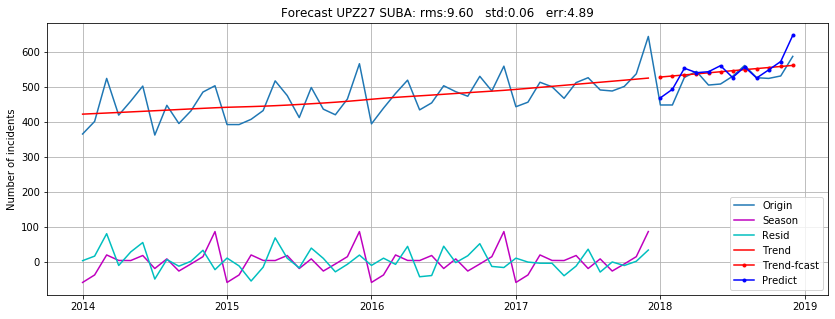

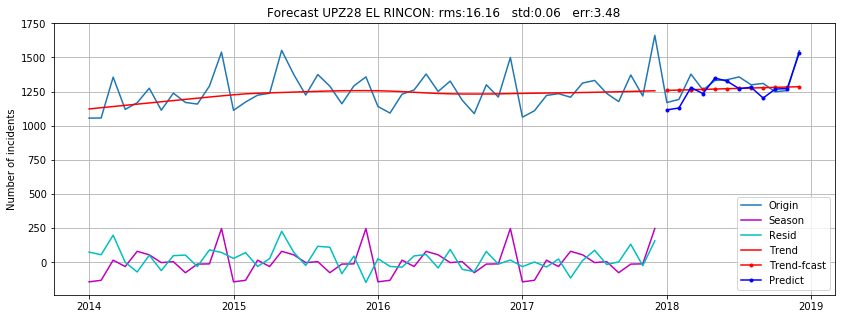

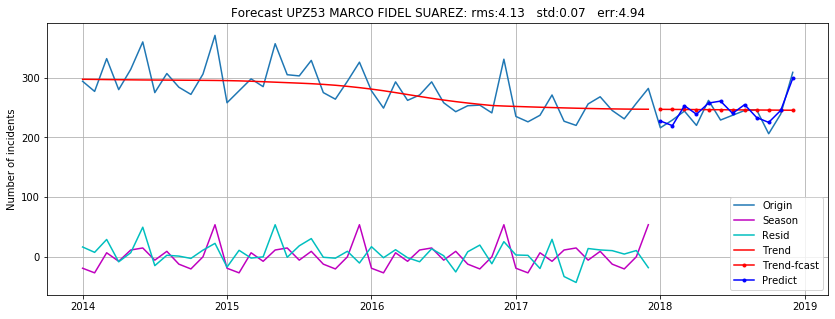

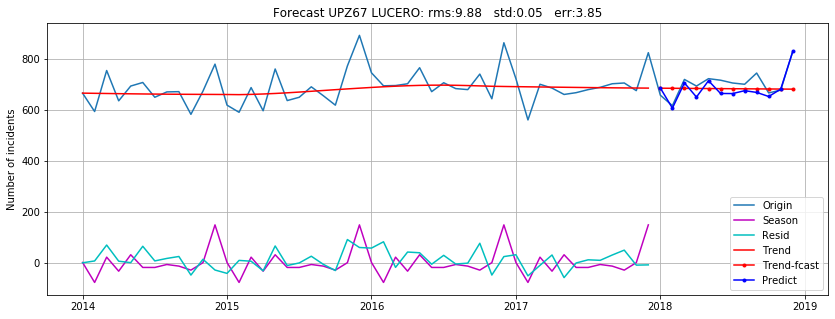

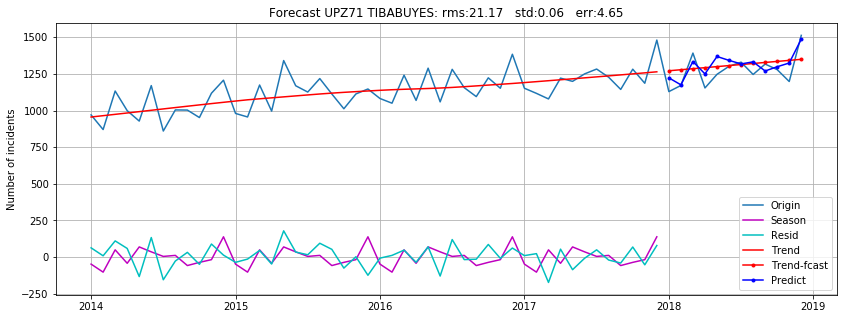

In [92]:
k1 = 60 # total times of month samples
k2 = 48 # number of points to train
k3 = k1-k2
lerr = []
lvar = []
for u in lupz:
    sdata = dfi[dfi['COD_UPZ']==u]['EVENTS']
    xx = [x/12+2014 for x in range(k1)]
    ndx = [pd.Timestamp(2014+x, y+1, 1) for x in range(6) for y in range(12)]
    dfu = pd.DataFrame(sdata.values, index=ndx, columns=['E']).head(k1)

    dfu1 = dfu.head(k2)
    dec1 = decompose(dfu1, period=12)
    fcast = forecast(dec1, steps=k3, fc_func=drift)
    fcast2 = forecast(dec1, steps=k3, fc_func=drift, seasonal=True)
    rms = np.sum((fcast2.iloc[:,0].values - dfu['E'][k2:k1].values)**2)**0.5/k3
    err = 100*np.sum(abs(fcast2.iloc[:,0].values - dfu['E'][k2:k1].values)/fcast['drift'].values)/k3
    des = np.std(dec1.resid.E) / np.mean(dfu.E)
    if err > 40: err = 40
    lerr.append(err)
    lvar.append(des)
    if err > 5: continue
    
    plt.figure(figsize=(14,5), facecolor='white')
    plt.plot(xx, dfu.E, label='Origin')
    plt.plot(xx[:k2], dec1.seasonal.E, 'm', label='Season')
    plt.plot(xx[:k2], dec1.resid.E, 'c', label='Resid')
    plt.plot(xx[:k2], dec1.trend.E, 'r', label='Trend')
    plt.plot(xx[k2:], fcast.drift, 'r.-', label='Trend-fcast')
    plt.plot(xx[k2:], fcast2['drift+seasonal'], 'b.-', label='Predict')
    plt.title('Forecast %s %s: rms:%1.2f   std:%1.2f   err:%1.2f'%(u,get_upz(u),rms, des, err))
    plt.legend(); plt.ylabel('Number of incidents'); plt.grid(True); plt.show()
lerr = np.array(lerr)
lvar = np.array(lvar)

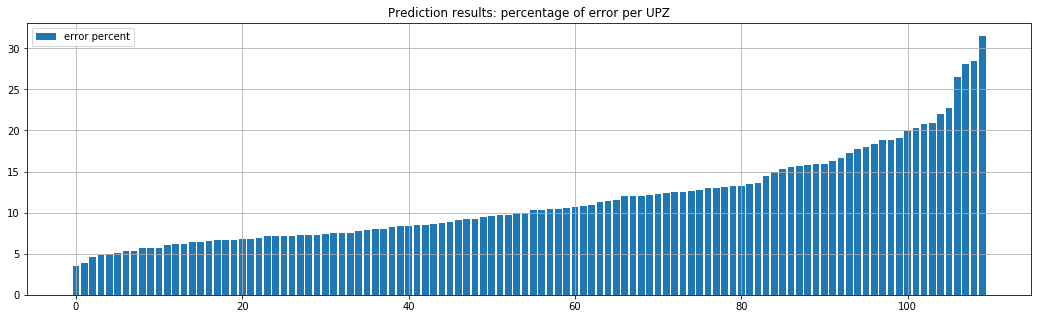

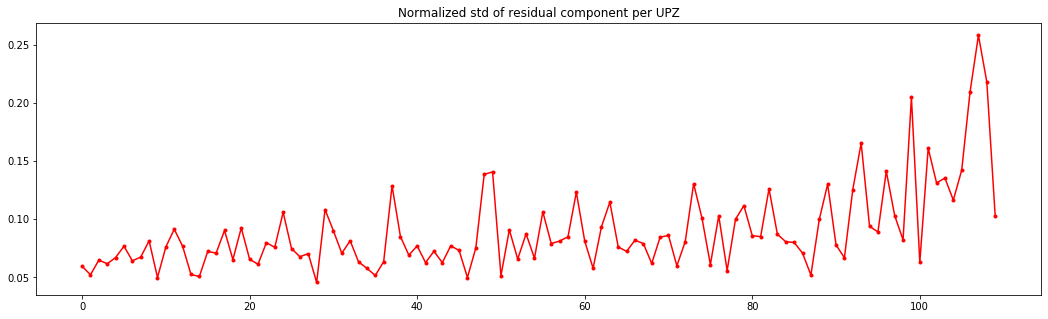

In [84]:
ndx = np.argsort(lerr)
plt.figure(figsize=(18,5), facecolor='white')
plt.bar(list(range(110)),lerr[ndx[:110]], label="error percent")
plt.title('Prediction results: percentage of error per UPZ')
plt.legend(); plt.grid(); plt.show()
plt.figure(figsize=(18,5), facecolor='white')
plt.plot(lvar[ndx[:110]], 'r.-')
plt.title('Normalized std of residual component per UPZ')
plt.show()

# Conclusions
- Se aprecia una tendencia entre el porcentaje de error y la varianza

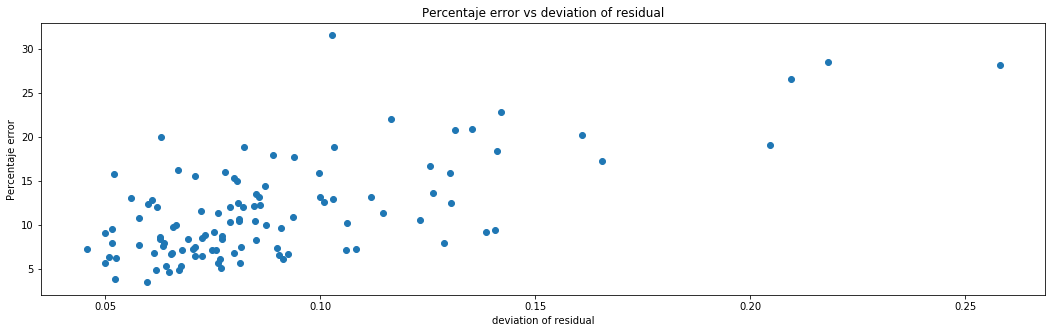

In [89]:
plt.figure(figsize=(18,5), facecolor='white')
plt.plot(lvar[ndx[:110]], lerr[ndx[:110]], 'o')
plt.title('Percentaje error vs deviation of residual')
plt.xlabel('deviation of residual'); plt.ylabel('Percentaje error'); plt.show()